https://pymc-devs.github.io/pymc3/notebooks/BEST.html

# Bayesian Estimation Supersedes the T-Test
This model replicates the example used in: Kruschke, John. (2012) Bayesian estimation supersedes the t-test. Journal of Experimental Psychology: General.

The original pymc2 implementation was written by Andrew Straw and can be found here: https://github.com/strawlab/best

Ported to PyMC3 by Thomas Wiecki (c) 2015, updated by Chris Fonnesbeck.

## The Problem
Several statistical inference procedures involve the comparison of two groups. We may be interested in whether one group is larger than another, or simply different from the other. We require a statistical model for this because true differences are usually accompanied by measurement or stochastic noise that prevent us from drawing conclusions simply from differences calculated from the observed data.

The de facto standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. This rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

Unfortunately, it is not easy to conduct hypothesis tests correctly, and their results are very easy to misinterpret. Setting up a statistical test involves several subjective choices (e.g. statistical test to use, null hypothesis to test, significance level) by the user that are rarely justified based on the problem or decision at hand, but rather, are usually based on traditional choices that are entirely arbitrary (Johnson 1999). The evidence that it provides to the user is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

A more informative and effective approach for comparing groups is one based on estimation rather than testing, and is driven by Bayesian probability rather than frequentist. That is, rather than testing whether two groups are different, we instead pursue an estimate of how different they are, which is fundamentally more informative. Moreover, we include an estimate of uncertainty associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (epistemic uncertainty) and uncertainty due to the inherent stochasticity of the system (aleatory uncertainty).

## Example: Drug trial evaluation
To illustrate how this Bayesian estimation approach works in practice, we will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a “smart drug” that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

In [1]:
%matplotlib inline
#%matplotlib notebook
%load_ext version_information
%load_ext autoreload


In [7]:
import datetime
import os
import sys
import warnings

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
import spacepy.datamodel as dm
import spacepy.plot as spp
import spacepy.toolbox as tb
import pandas as pd
import pymc3 as pm
import seaborn as sns

%version_information matplotlib, numpy, pandas, pymc3, seaborn

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
matplotlib 2.0.2
numpy 1.13.1
pandas 0.20.3
pymc3 3.1
seaborn 0.8.0
Thu Aug 10 10:30:53 2017 MDT

In [8]:
FIGDIR = os.path.join('..', 'figures')
SRCDIR = os.path.join('..', 'src')
DEVDIR = os.path.join('..', 'develop')
DELDIR = os.path.join('..', 'deliver')
DATDIR = os.path.join('..', 'data')
sys.path.append(SRCDIR)

In [9]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['savefig.dpi'] = plt.rcParams['figure.dpi'] # 72
%config InlineBackend.figure_format = 'retina'

In [10]:
np.random.seed(20090425)


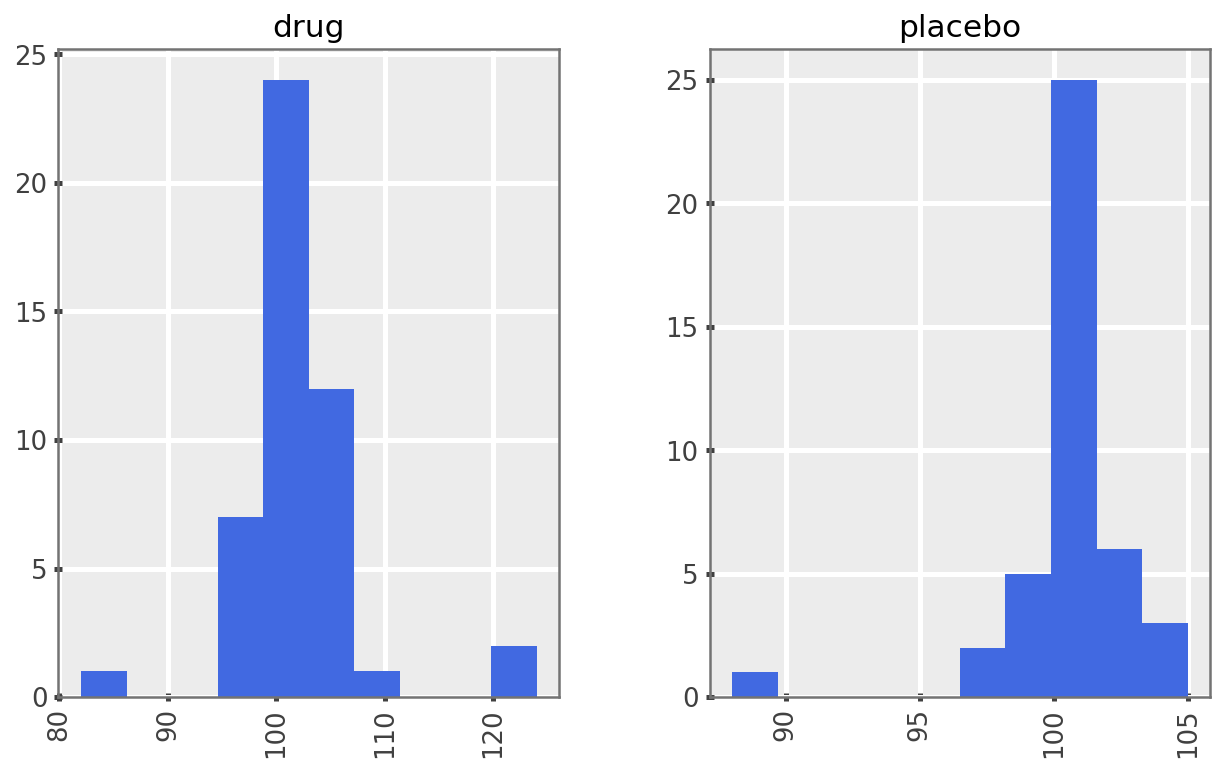

In [11]:

drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

y1 = np.array(drug)
y2 = np.array(placebo)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))

y.hist('value', by='group');

The first step in a Bayesian approach to inference is to specify the full probability model that corresponds to the problem. For this example, Kruschke chooses a Student-t distribution to describe the distributions of the scores in each group. This choice adds robustness to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. The three-parameter Student-t distribution allows for the specification of a mean μμ, a precision (inverse-variance) λλ and a degrees-of-freedom parameter νν:

$f(x|μ,λ,ν)=Γ(ν+12)Γ(ν2)(λπν)12[1+λ(x−μ)2ν]−ν+12$

$f(x|μ,λ,ν)=Γ(ν+12)Γ(ν2)(λπν)12[1+λ(x−μ)2ν]−ν+12$

the degrees-of-freedom parameter essentially specifies the “normality” of the data, since larger values of νν make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

Thus, the likelihood functions of our model are specified as follows:

y(treat)i∼T(ν,μ1,σ1)
yi(treat)∼T(ν,μ1,σ1)
y(placebo)i∼T(ν,μ2,σ2)
yi(placebo)∼T(ν,μ2,σ2)
As a simplifying assumption, we will assume that the degree of normality νν is the same for both groups. We will, of course, have separate parameters for the means μk,k=1,2μk,k=1,2 and standard deviations σkσk.

Since the means are real-valued, we will apply normal priors on them, and arbitrarily set the hyperparameters to the pooled empirical mean of the data and twice the pooled empirical standard deviation, which applies very diffuse information to these quantities (and importantly, does not favor one or the other a priori).

μk∼N(x¯,2s)

In [24]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', μ_m, sd=μ_s)

In [25]:
σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

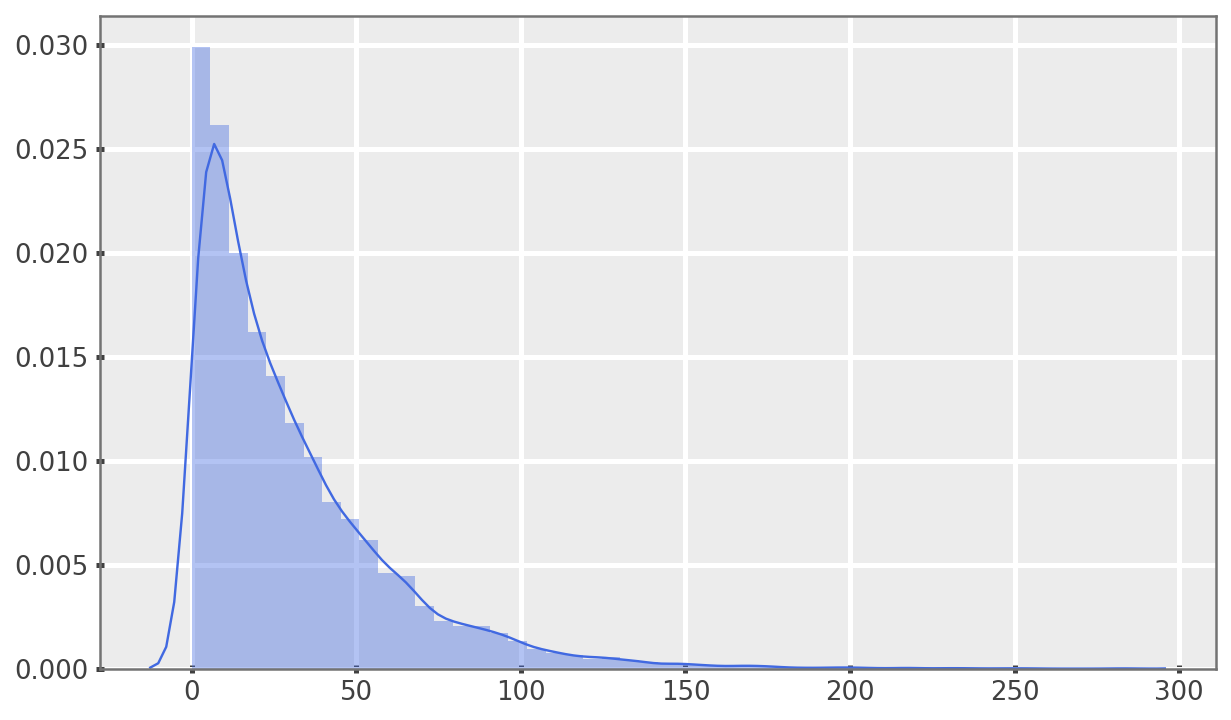

In [26]:
with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

sns.distplot(np.random.exponential(30, size=10000), kde=True);

In [27]:
with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [28]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [29]:
with model:
    trace = pm.sample(2000, init=None, njobs=4)

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval__
Assigned NUTS to group2_std_interval__
Assigned NUTS to ν_minus_one_log__
100%|██████████| 2500/2500 [00:09<00:00, 273.33it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a496550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e8ca128>]], dtype=object)

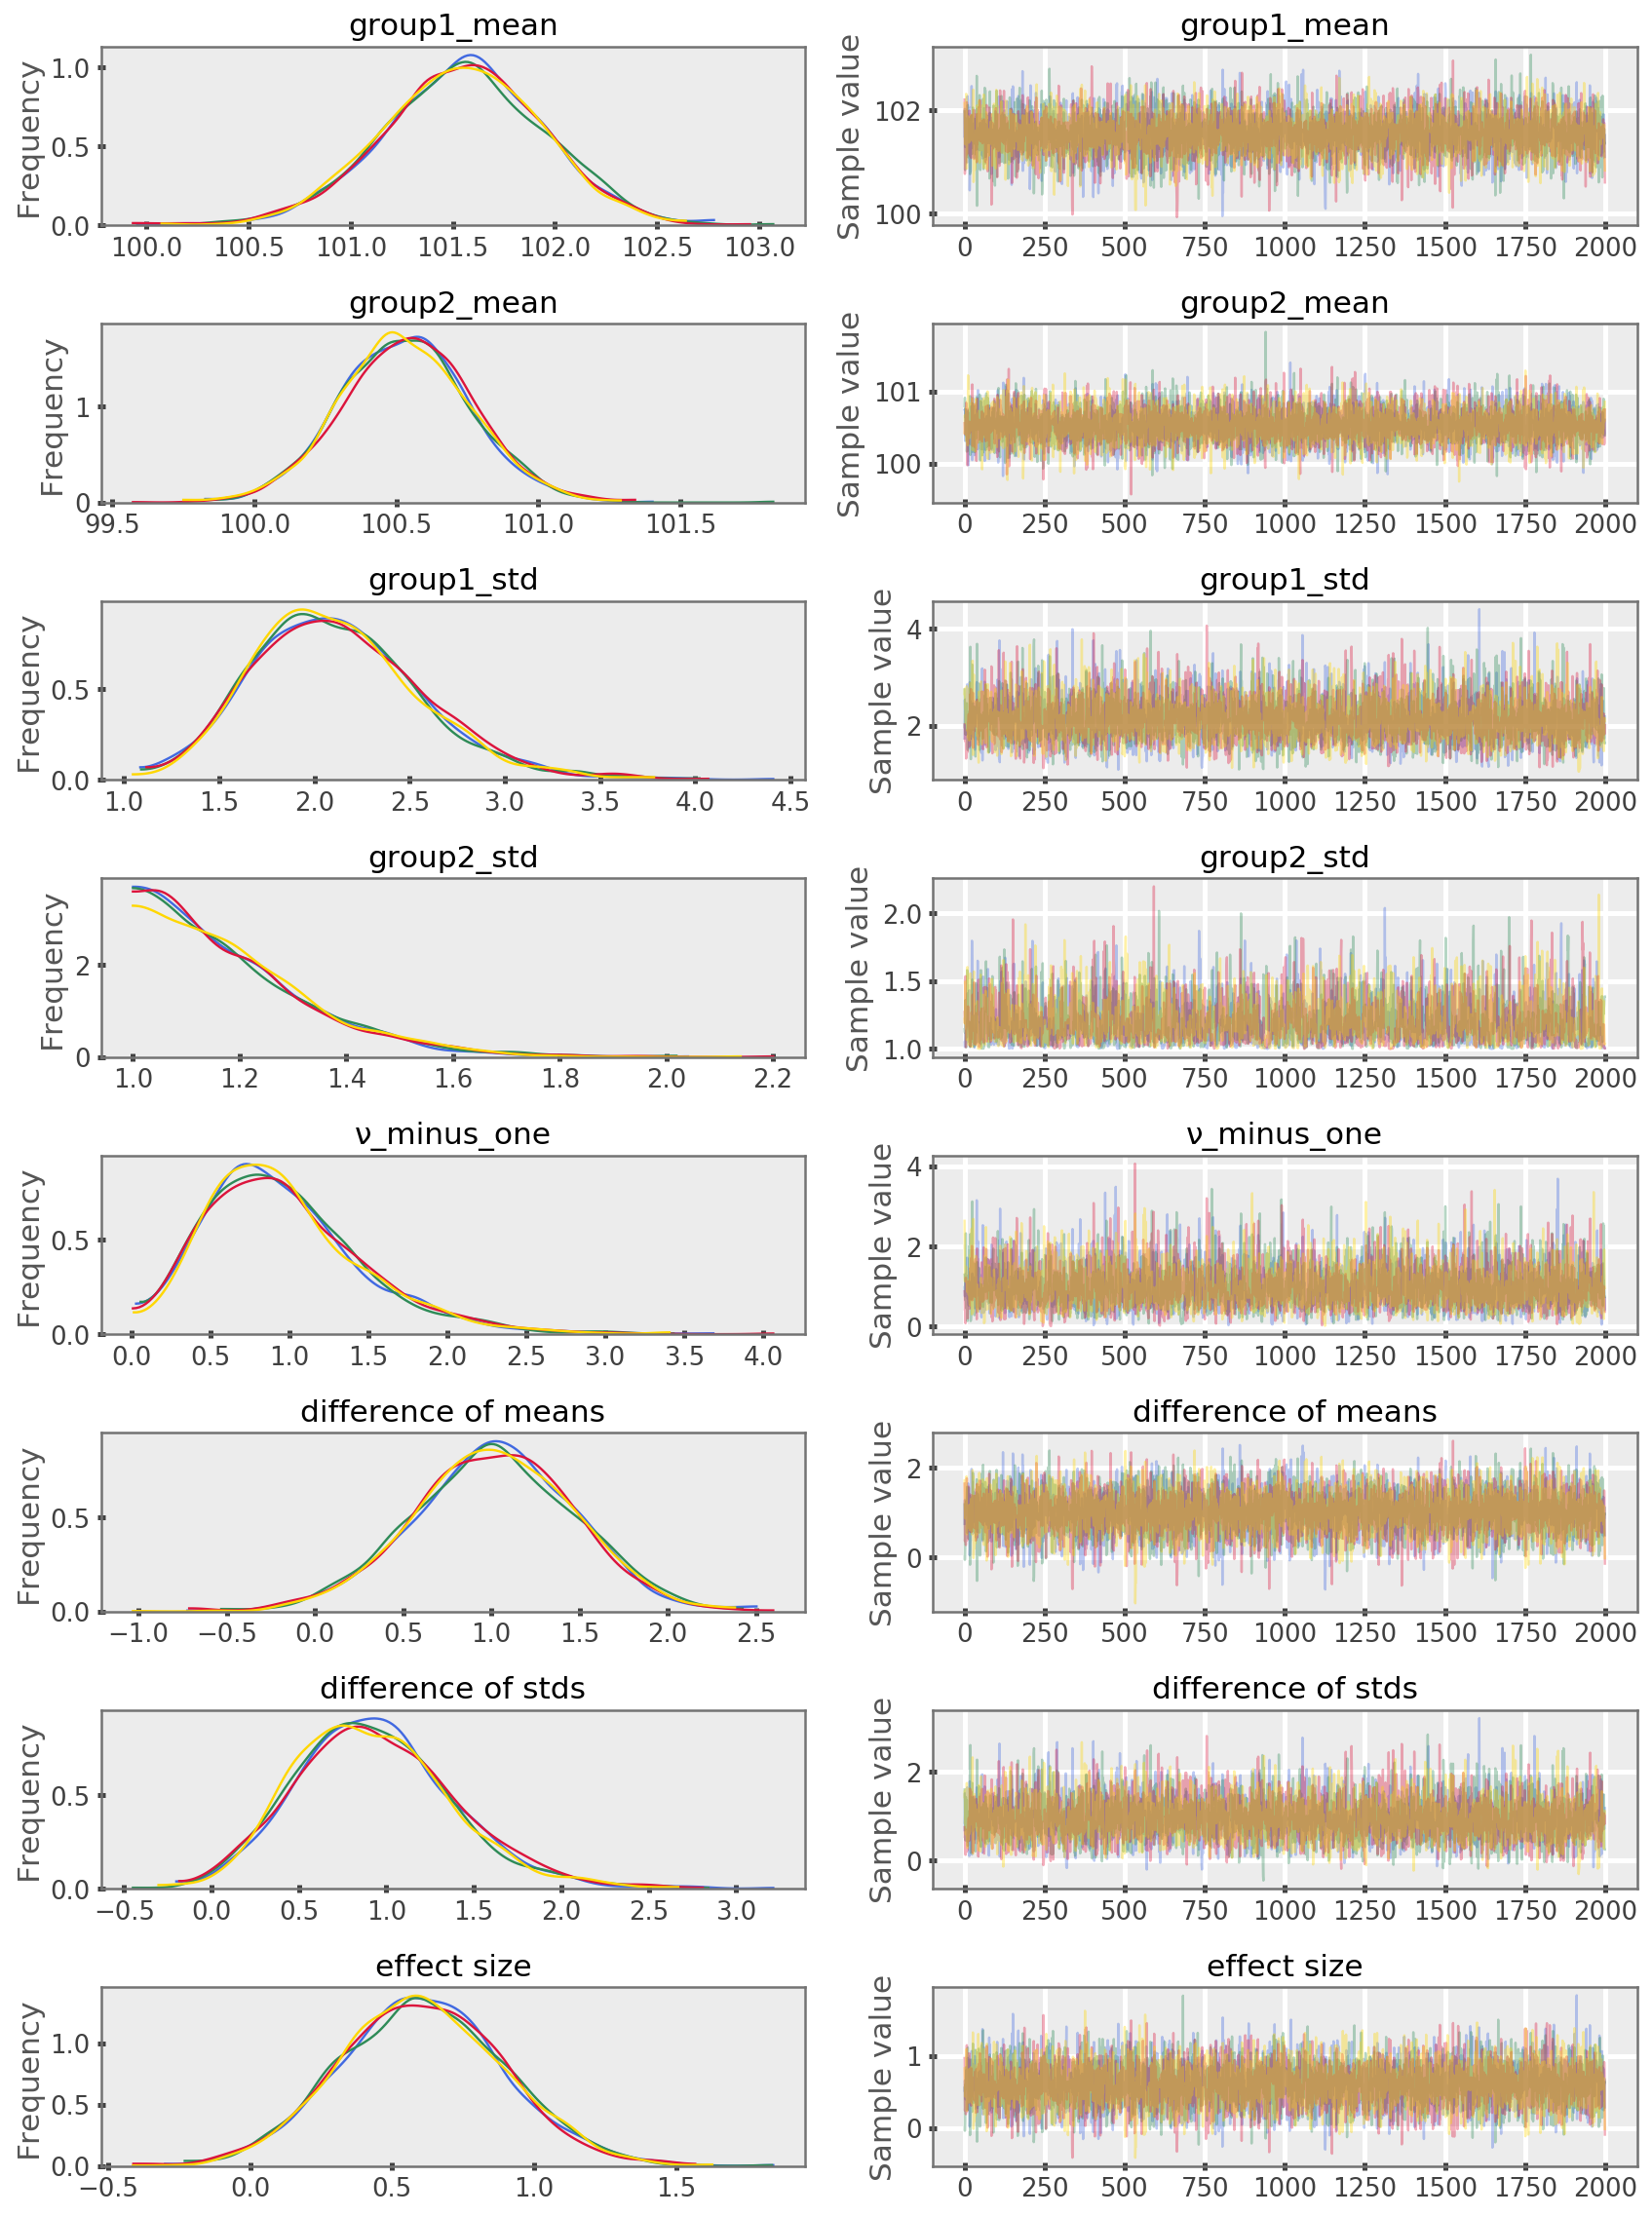

In [30]:
pm.traceplot(trace)

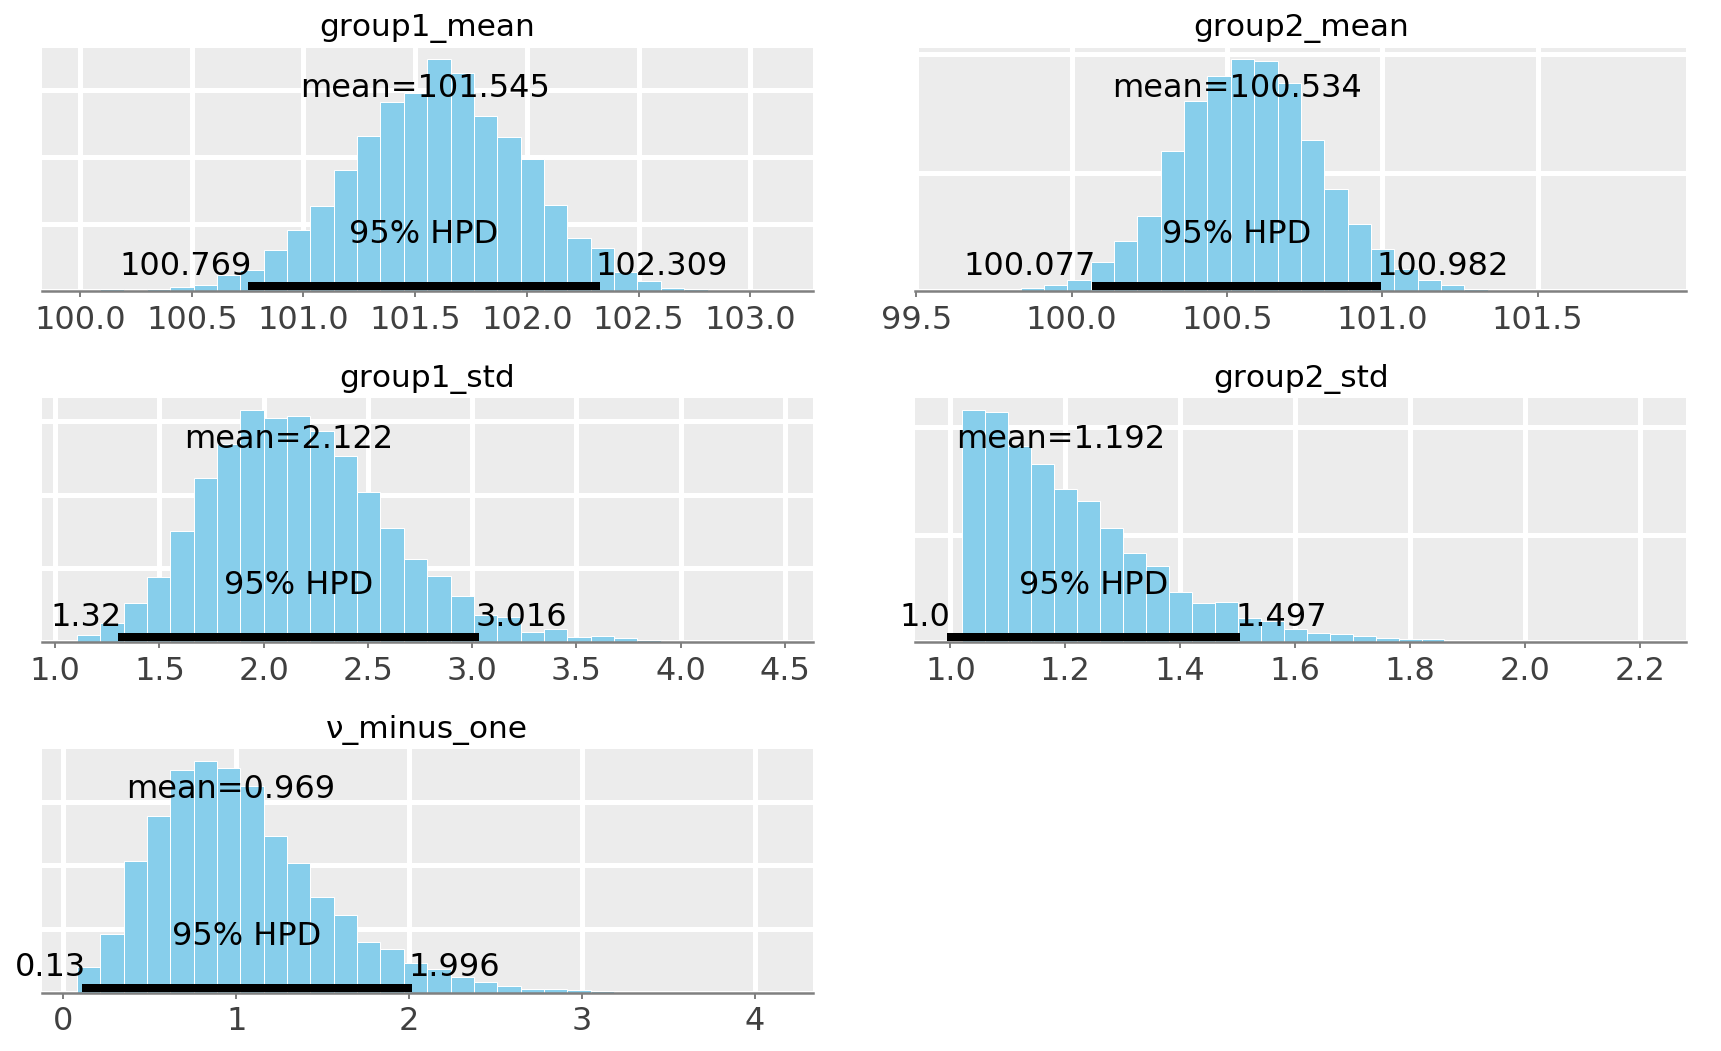

In [31]:
pm.plot_posterior(trace[100:],
                  varnames=['group1_mean', 'group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

# Does this change at all if we bound the dists for physical rasons at 0?

In [38]:
μ_m = y.value.mean()
μ_s = y.value.std() * 2
μ_m, μ_s

(101.17977528089888, 9.4895243570467027)

In [41]:
BoundedNormal = pm.Bound(pm.Normal, lower=0)
with pm.Model() as model:
    group1_mean = BoundedNormal('group1_mean', μ_m, sd=μ_s)
    group2_mean = BoundedNormal('group2_mean', μ_m, sd=μ_s)


AttributeError: 'numpy.float64' object has no attribute 'name'

Assigned NUTS to group1_mean_interval__
Assigned NUTS to group2_mean_interval__
Assigned NUTS to group1_std_interval__
Assigned NUTS to group2_std_interval__
Assigned NUTS to ν_minus_one_log__
100%|██████████| 2500/2500 [05:40<00:00,  7.33it/s]


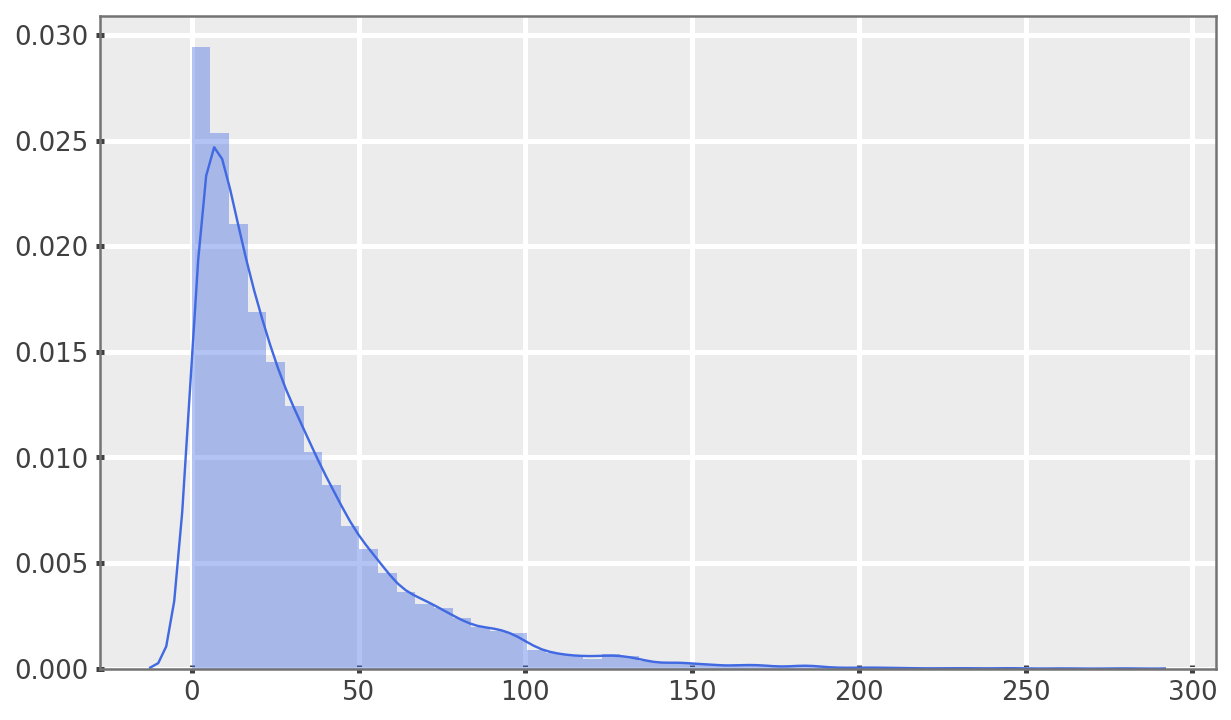

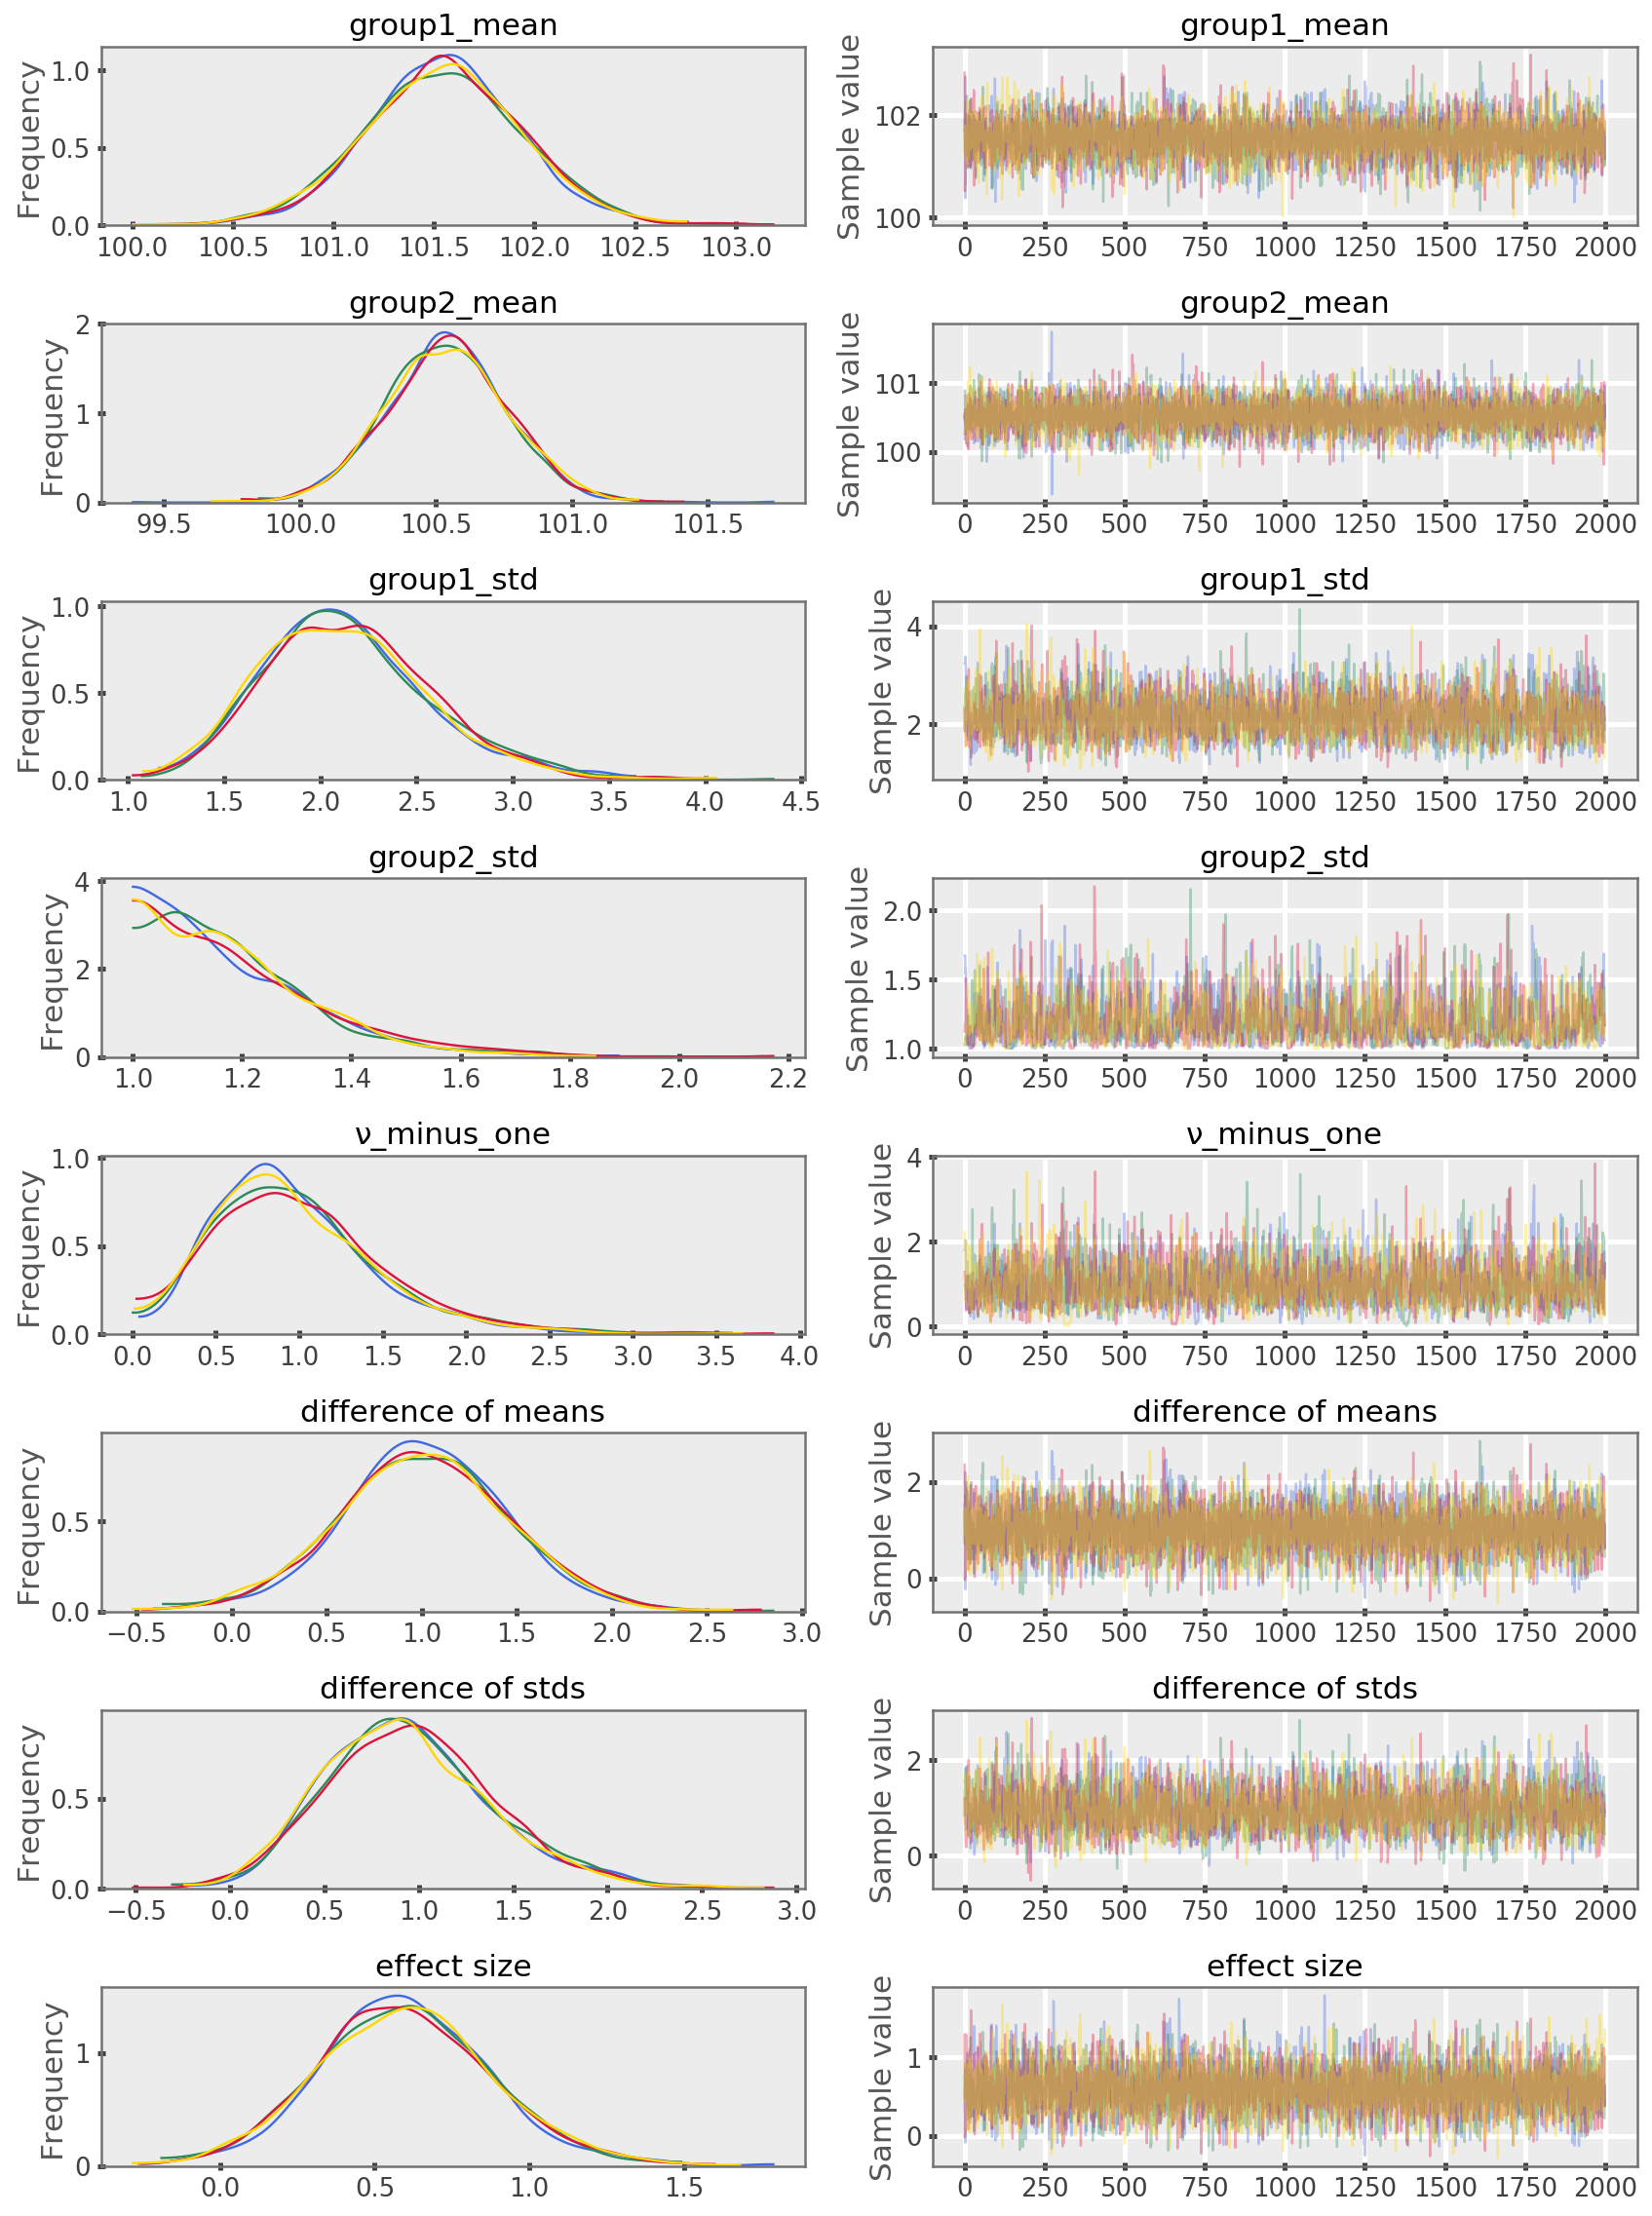

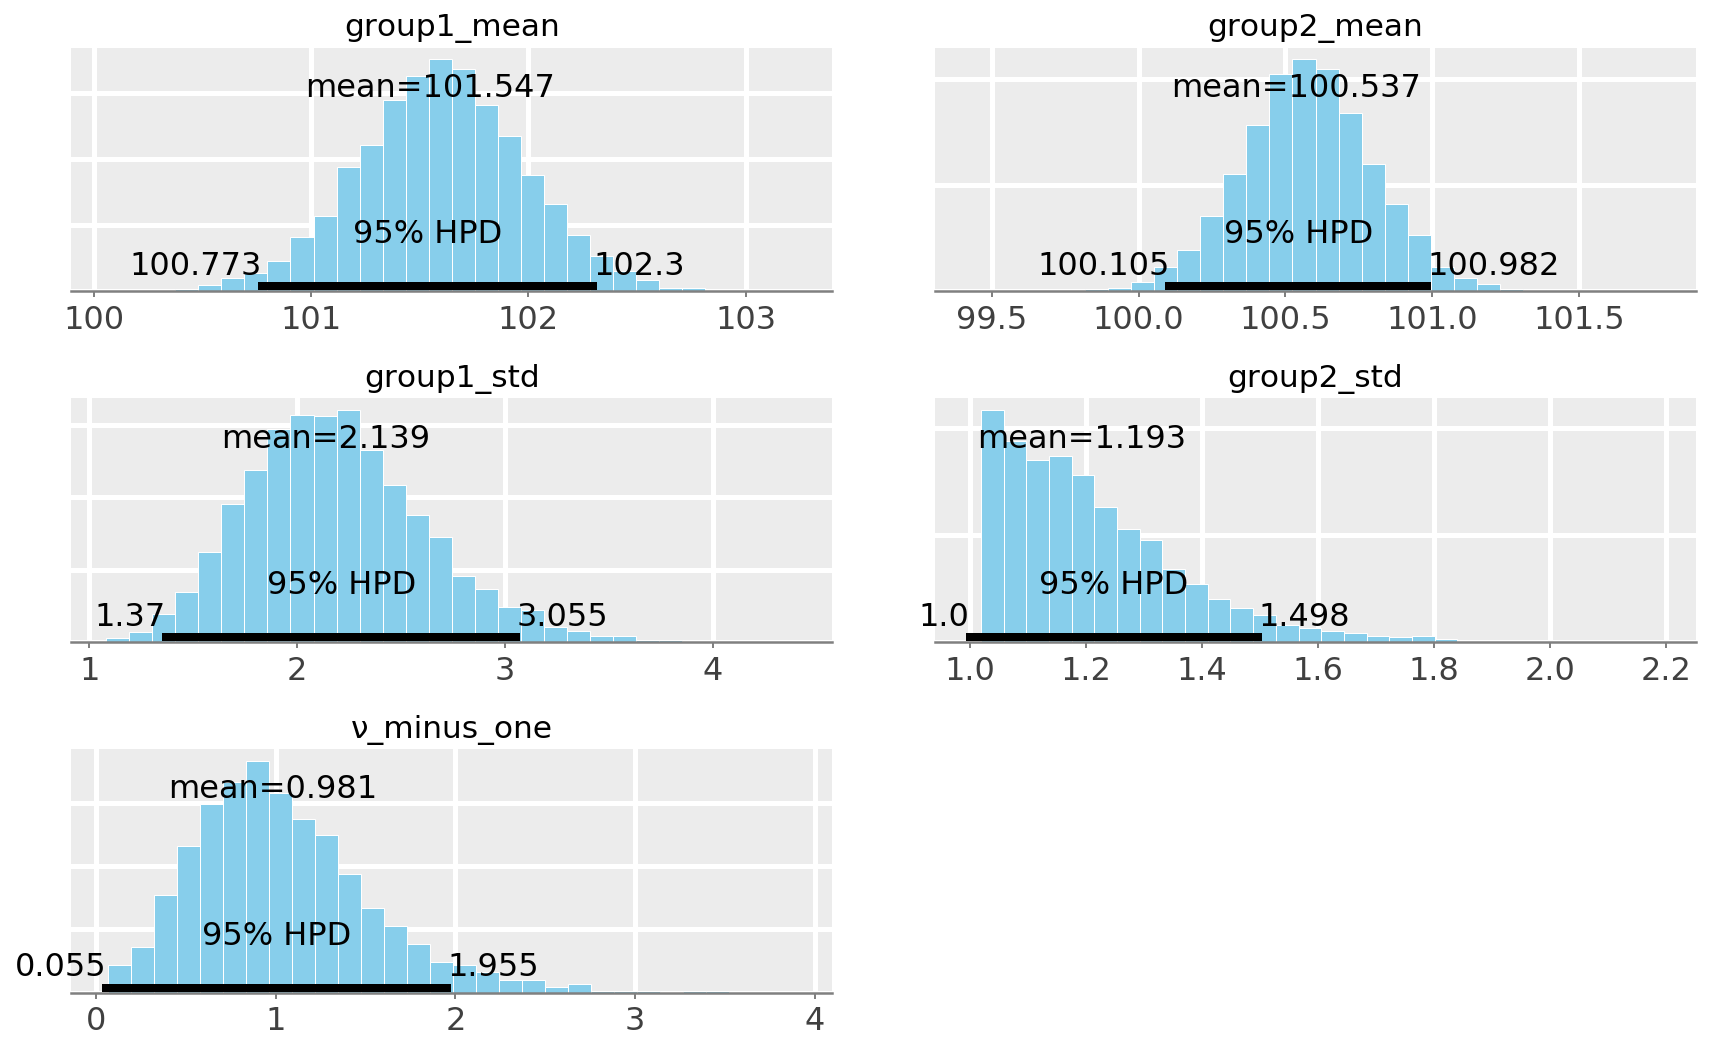

In [42]:


BoundedNormal = pm.Bound(pm.Normal, lower=0)

with pm.Model() as model:
    group1_mean = pm.Uniform('group1_mean', 0, μ_m*5)
    group2_mean = pm.Uniform('group2_mean', 0, μ_m*5)

σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

sns.distplot(np.random.exponential(30, size=10000), kde=True);

with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


with model:
    trace = pm.sample(2000, init=None, njobs=4)

pm.traceplot(trace)

pm.plot_posterior(trace[100:],
                  varnames=['group1_mean', 'group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

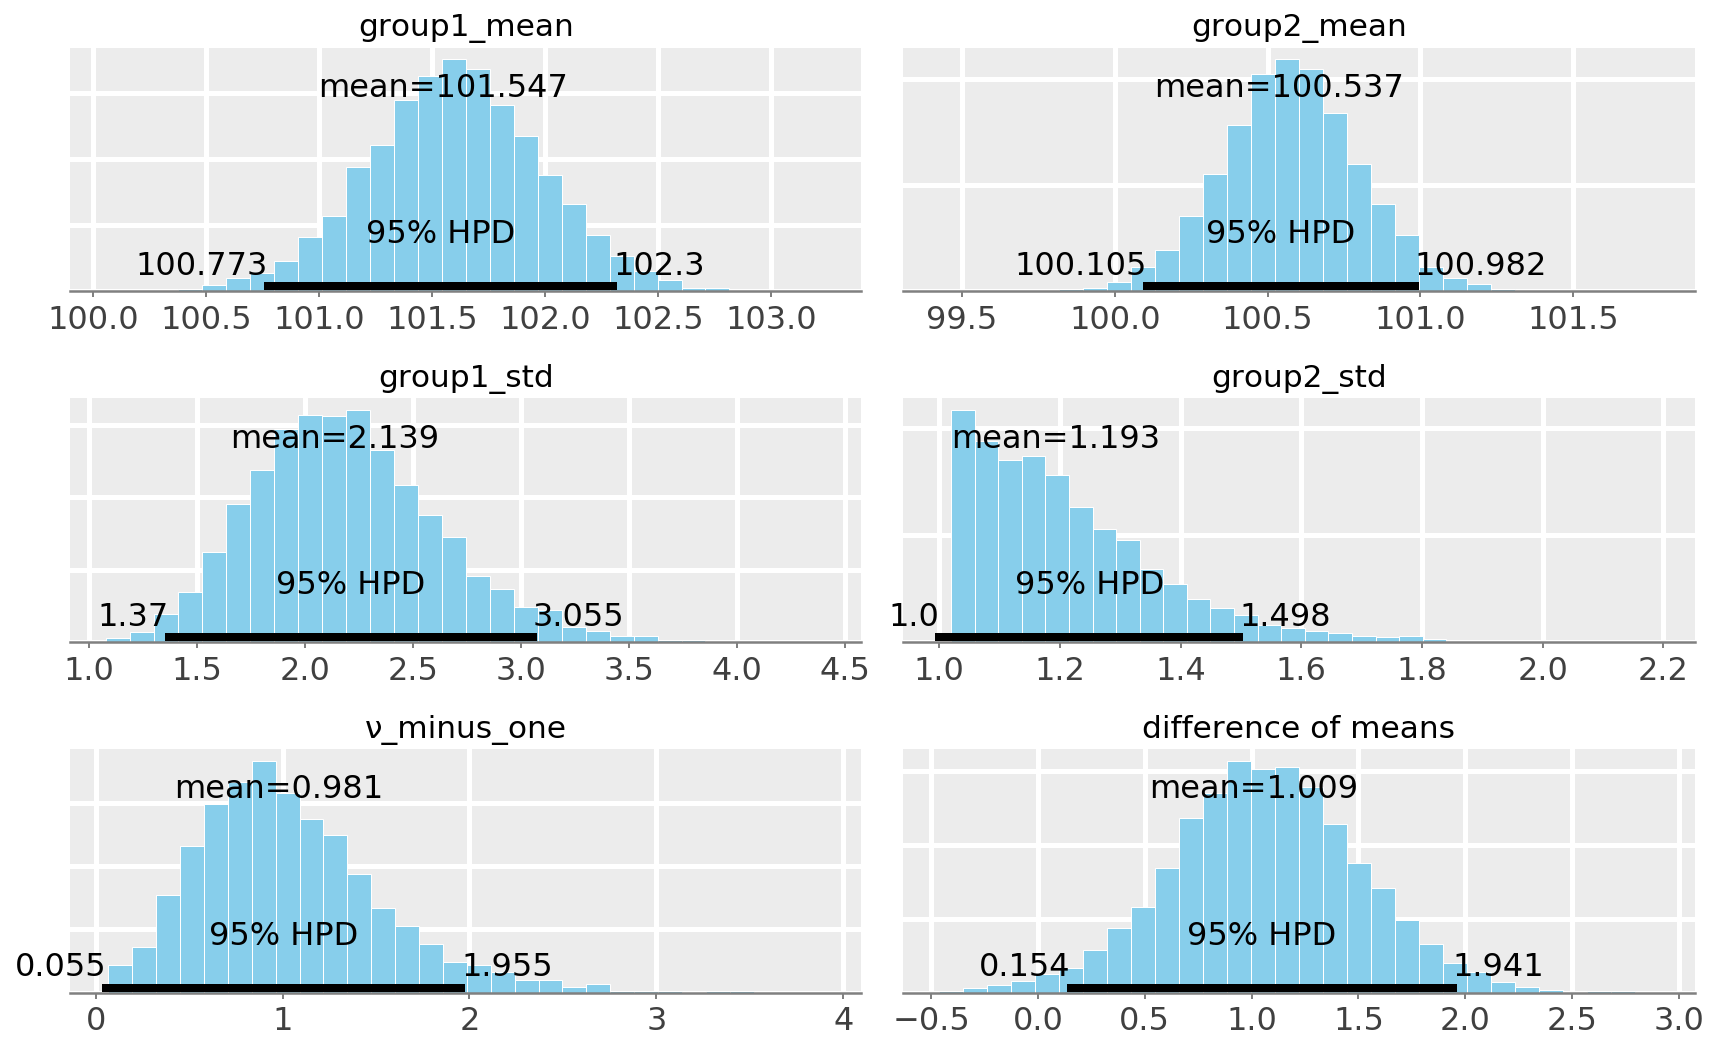

In [43]:
pm.plot_posterior(trace[100:],
                  varnames=['group1_mean', 'group2_mean', 'group1_std', 'group2_std', 'ν_minus_one', 'difference of means'],
                  color='#87ceeb');

In [46]:
pm.summary(trace)


group1_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  101.546          0.388            0.005            [100.807, 102.338]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  100.775        101.293        101.549        101.801        102.309


group2_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  100.537          0.224            0.003            [100.104, 100.982]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  100.094        100.389        100.538        100.682        100.977


group1_std:

  Mean             SD               MC Error         95% HPD interva

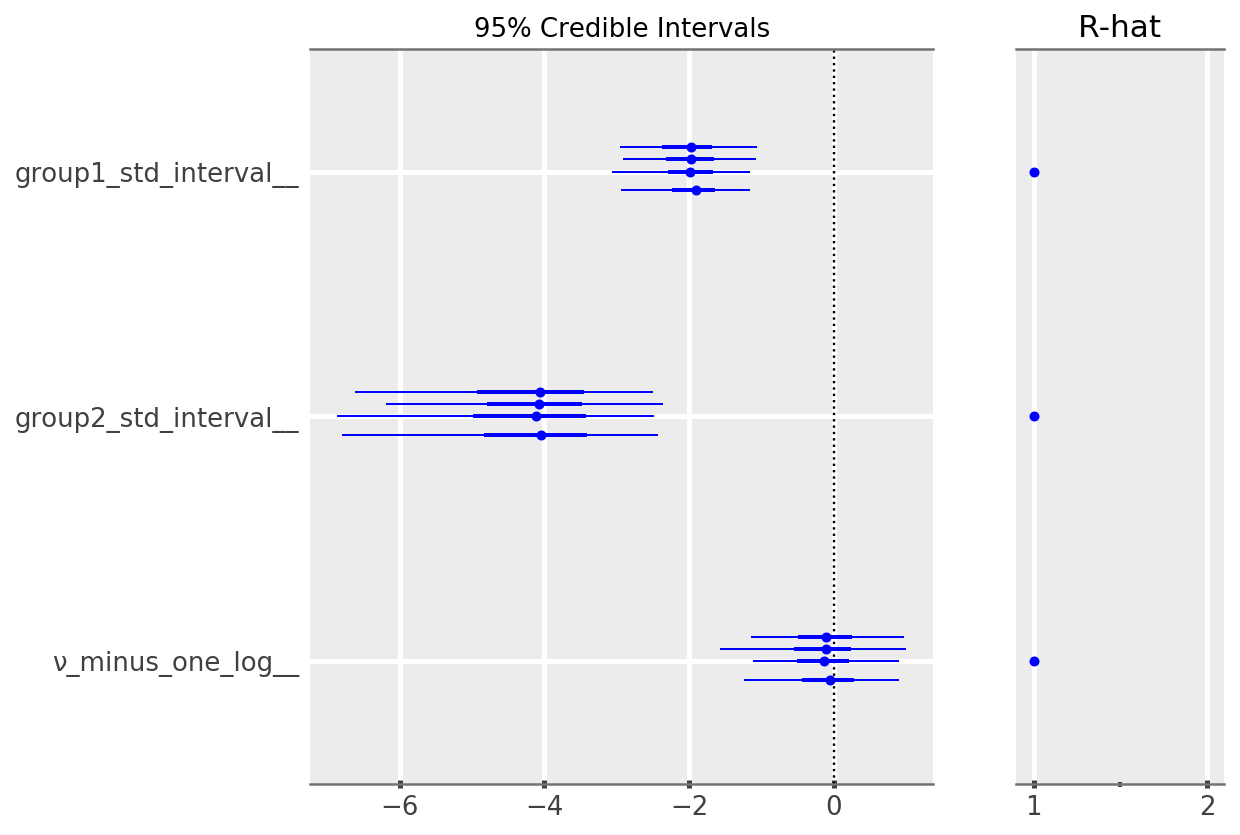

In [47]:
pm.forestplot(trace[1000:], varnames=[v.name for v in model.vars[2:]])
